In [14]:
import koreanize_matplotlib
koreanize_matplotlib.koreanize()

In [1]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
pd.options.plotting.backend = "plotly"

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 자기 상관성 (Autocorrelation) ##

### 1. 기본 개념

자기상관(Autocorrelation)은 시계열 데이터에서 <font color="red">시간 지연(lag)에 따른 데이터 포인트 간의 상관 관계를 측정.</font>

예를 들어, 오늘의 주식 가격이 어제의 주식 가격과 얼마나 관련이 있는지를 측정함.


### 2. 부분 자기상관(Partial Autocorrelation)의 필요성

자기상관만을 사용할 때, 특정 시간 지연에서의 상관 관계가 그 이전 시간 지연들의 영향을 받게 됨.

부분 자기상관은 특정 시간 지연 $k$에서의 상관 관계를 측정할 때, <font color="red">그 사이에 있는 다른 모든 시간 지연의 영향을 제거한 후</font>의 상관 관계를 측정.

예를 들어, 오늘의 주식 가격이 어제의 가격과, 그제의 가격과 모두 관련이 있을 때, 

단순 자기상관으로는 그 관계를 명확히 이해하기 어려움.

부분 자기상관은 이러한 <font color="red">간접적인 영향을 제거하여 직접적인 상관 관계를 측정</font>함.



### 3. 수학적 계산원리
- [Yule-Walker 방정식](https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters)의 비재귀적 방식 이용
- [토플리츠 대각선 상수 행렬](https://en.wikipedia.org/wiki/Toeplitz_matrix)과 [레빈슨-더빈 재귀 알고리즘](https://en.wikipedia.org/wiki/Levinson_recursion)으로 연산

- pacf 함수를 사용하여 간단히 계산 가능.

    - 1차 자기상관(\(k=1\))을 구한 후,

    - 2차 자기상관(\(k=2\))에서는 1차 자기상관의 영향을 제거하고,
    - 3차 자기상관(\(k=3\))에서는 1차와 2차 자기상관의 영향을 제거하는 방식.

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# 데이터 로드
census = pd.read_csv('./Data/korean-births-stats.csv', index_col=0, parse_dates=True)
census.replace('-', np.nan, inplace=True)
census.index.freq = 'MS'
census.head()


,출생아수,사망자수,혼인건수,이혼건수
1981-01-01,88151.0,NaN,49285.0,1827.0
1981-02-01,93556.0,NaN,34481.0,1687.0
1981-03-01,70421.0,NaN,47843.0,2094.0
1981-04-01,66093.0,NaN,35956.0,2189.0
1981-05-01,68940.0,NaN,35769.0,2059.0


자기상관성의 시각적 이해

In [8]:
# 모든 컬럼을 float 타입으로 변환
census = census.astype(float)
census.plot()


In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=census['출생아수'].iloc[:-1], y=census['출생아수'].iloc[1:], mode='markers'))
fig.show()

In [ ]:
# 선형성을 보이므로 자기 상관성이 높다는 강한 증거있다고 확신할수 있음.

Yule-Walker 방정식을 통한 부분자기상관 계산 예제

In [11]:
# 부분자기상관 함수 계산
pacf_vals = pacf_yw(census['출생아수'], nlags=20) # nlags : 부분자기상관 함수 계산 시 사용할 대기 시간 수

# # x와 y의 길이를 맞추기 위해 pacf_vals의 첫 번째 값을 제거
pacf_vals = pacf_vals[1:]

px.bar(x=range(1, 21), y=pacf_vals, title='부분 자기상관 함수 (PACF) - Yule-Walker 방법').show()


* 해석:
> - x축은 시차(lag), y축은 해당 시차에서의 부분 자기상관 계수를 의미합니다.
> - lag 1에서 부분 자기상관 계수가 0.7 이상으로 매우 높게 나타나며, 이는 직전 시점의 데이터가 현재 데이터에 강한 영향을 미친다는 것을 의미합니다.
> - 이후 lag에서는 부분 자기상관 계수가 대부분 0에 가깝거나, 일부 lag(예: 11)에서 음의 값으로 크게 나타납니다.
> - lag 11에서 음의 부분 자기상관이 뚜렷하게 나타나는 것은 11개월 주기의 음의 상관관계가 존재함을 시사할 수 있습니다.
> - 전반적으로 lag 1 이후에는 부분 자기상관이 급격히 감소하므로, AR(1) 또는 AR(1)+주기성 모델이 적합할 수 있음을 시사합니다.


내장함수를 이용한 자기상관 시각화

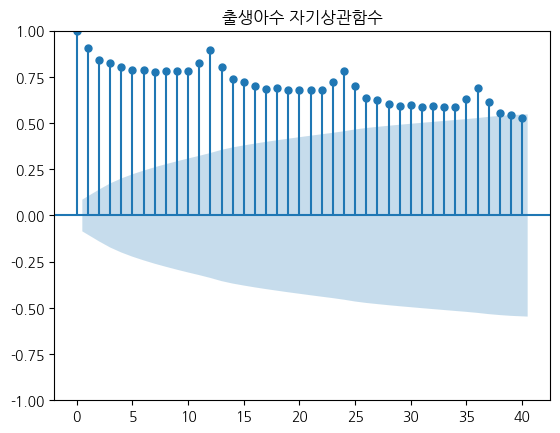

In [15]:
# 시계열 데이터의 값이 시간에 따라 얼마나 상관되어 있는지를 나타냄.
plot_acf(census['출생아수'],title='출생아수 자기상관함수',lags=40);

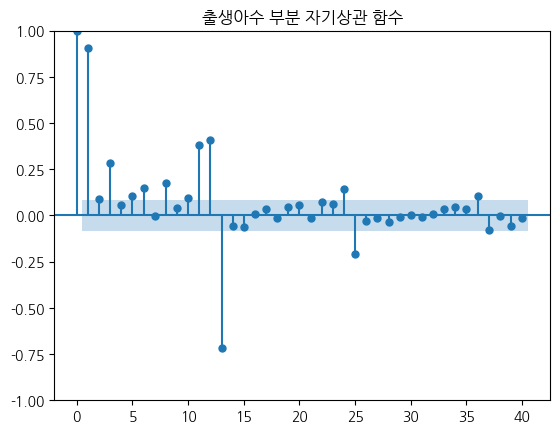

In [16]:
# 특정 시차에서의 부분 자기상관을 나타내며, 이전 시차들의 영향을 배제한 순수한 자기상관을 나타냄
plot_pacf(census['출생아수'],title='출생아수 부분 자기상관 함수',lags=40);

#### 일반적 해석 방법

1. ACF 그래프
   
   - **신속한 감소**: ACF가 특정 시차 이후 급격히 감소하면, 데이터가 AR(Autoregressive) 프로세스를 따를 가능성이 커짐.
      * 이는 현재 값이 이전 값들과의 직접적인 선형 관계를 가지고 있음을 의미
      * 예를 들어, AR(1) 모델에서는 현재 값이 직전 시점의 값에 크게 의존
      * 급격한 감소는 이전 값들의 영향이 빠르게 사라짐을 나타냄
   
   - **지속적인 감소**: ACF가 천천히 감소하면, 데이터가 MA(Moving Average) 프로세스를 따를 가능성이 커짐.
      * 이는 현재 값이 이전의 여러 시점의 오차항들의 영향을 받고 있음을 의미
      * MA 프로세스는 이전 시점들의 오차가 현재 값에 영향을 미치는 구조
      * 천천히 감소하는 것은 이전 시점들의 영향이 오래 지속됨을 나타냄

2. PACF 그래프
   
   - **신속한 감소**: PACF가 특정 시차 이후 급격히 감소하면, 데이터가 AR 프로세스를 따를 가능성이 커짐.
      * PACF는 이전 시차들의 영향을 제거한 순수한 자기상관을 보여줌
      * AR 프로세스에서는 현재 값이 이전 값들과 직접적인 관계를 가짐
      * 급격한 감소는 이전 값들의 직접적인 영향이 빠르게 사라짐을 의미
   
   - **지속적인 감소**: PACF가 천천히 감소하면, 데이터가 MA 프로세스를 따를 가능성이 커짐.
      * MA 프로세스는 이전 시점들의 오차항들의 영향을 받는 구조
      * PACF가 천천히 감소하는 것은 이전 시점들의 오차 영향이 오래 지속됨을 나타냄
      * 이는 현재 값이 여러 이전 시점의 오차항들과 복잡한 관계를 가짐을 의미


#### 출생아수 데이터에 대한 해석
* ACF 해석
	
	* LAG 0에서의 자기상관 계수는 항상 1 (자기 자신과의 상관관계이기 때문).
	
	* LAG 1에서의 자기상관 계수가 매우 높게 나타나며, 이는 최근 시점의 데이터가 이전 시점의 데이터와 높은 상관 관계가 있음을 나타냄.
	* 점진적 감소 및 양의 상관관계 유지: ACF 값이 LAG 1 이후로 점진적으로 감소하지만 여전히 양의 상관 관계를 유지. 이는 데이터에 장기적인 추세나 주기성이 존재할 가능성을 시사.

* PACF 해석
    
    * LAG1에서 매우 높은 부분 자기상관 계수과 관찰됨. 이는 AR(1) 모델이 적합하다고 판단할 증거가 됨.
    
    * LAG2 이후부터는 부분 자기상관 계수가 급격히 감소. 대부분의 LAG에서 0에 가까운 값을 나타냄. 다만 몇몇 지연에서 유의미한 값을 보임.
    * 특정 지연(약 10, 15, 20)에서의 급격한 변동이 나타남. 이는 데이터에 특정 주기나 구조적 변화가 있음을 시사.

* 해석에 대한 결론
    
    * 추세와 계절성: ACF 그래프에서 LAG가 커져도 여전히 양의 상관 관계가 유지되는 것은 데이터에 장기적인 추세나 계절성이 존재할 가능성이 있다고 볼수 있음. 특히, 일정한 주기로 높은 상관 관계를 유지하는 것은 계절성이 존재함을 시사함.
	
    * 모델 선택: PACF 그래프에서 LAG1이후의 부분 자기상관 계수가 급격히 감소하는 패턴은 <font color="yellow">AR(1) 모델</font>이 적합할 수 있음을 나타냄. 그러나 특정 지연에서의 급격한 변동은 <font color="yellow">추가적인 계절성 요소</font>를 고려해야 함을 시사함.



* 향후 모델 선택 전략
  
  * ARIMA 또는 SARIMA 모델중에 선택할수 할수 있지만, 일반적으로 출생아수가 시즌성이 있다고 생각하기 어려운점이 있음.
  
  * 따라서, 추세성을 반영한 모델을 다양하게 적합해보고 잔차 분석을 통해서 모델 타당성을 찾아가야 한다고 생각함.